In [1]:
using Plots, Random, Distributions, StatsBase, Printf, LaTeXStrings, 
    DataFrames, StatsPlots, KernelDensity, LinearAlgebra
default(fillcolor=:lightgrey, markercolor=:black, markersize=2,
    grid=false, legend=false, titlefontsize=10)

# Data Augmentations

## Mixture of Gaussians

We consider data $Y_1, \ldots, Y_n$, each of whic hcan come from one of the $K$ population. The distribution of $Y_i$ in the $k^{th}$ population is $N(\mu_k, 1/{\tau})$. We do not observe from which population each $Y_i$ come from. It is distribution is given by a *mixture distibution*:
$$\sum_{k = 1}^{K}\pi_k\phi_k(y_i)$$
Where $pi_k$ is the probability of belonging to population $k$ and $\phi_k$ is the density of $N(\mu_k, 1/ {\tau})$. For simplicity we assume that $\tau$ is known and common for all components of the mixture.

Priors:
$$
\begin{aligned}
\mu_k \sim N(\mu_0, 1/\tau_0) \\
(\pi_1, \ldots, \pi_K) &\sim Dir(\alpha_1, \ldots, \alpha_K)
\end{aligned}
$$

We introduce auxilary variables $Z_1, \ldots, Z_n$ indicating which population the $i$-th individuals come from.
$$\mathbb{P}(Z_i = k) = \pi_k \quad \text{ and } \quad  Y_i | Z_i \sim N(\mu_k, 1/\tau) $$

Posteriors:
$$
\begin{aligned}
\mathbb{P}(Z_i = k | Y_1, \ldots, Y_n, \mu_1, \ldots, \mu_K, \pi_1, \ldots, \pi_K) 
&= \frac{\pi_k\phi_k(y_i)}{\sum_{l=1}^{K}\pi_l\phi_l(y_i)} \\
\mu_k | Y_1, \ldots, Y_n, Z_1, \ldots, Z_n, \pi_1, \ldots, \pi_K 
&\sim N\left(\frac{\tau\left(\sum_{Z_i = k}y_i\right)+ \tau_0\mu_0}{\tau|\{i: Z_i = k\}| + \tau_0}, 
\frac{1}{\tau|\{i: Z_i = k\}| + \tau_0}\right) \\ 
\pi_1, \ldots, \pi_K | Y_1, \ldots, Y_n, Z_1, \ldots, Z_n, \mu_1, \ldots, \mu_K 
&\sim Dir\left(\alpha_1 + |\{i: Z_i = 1\}|, \ldots, \alpha_K + |\{i: Z_i = K\}|\right)
\end{aligned}
$$

### Simulated data

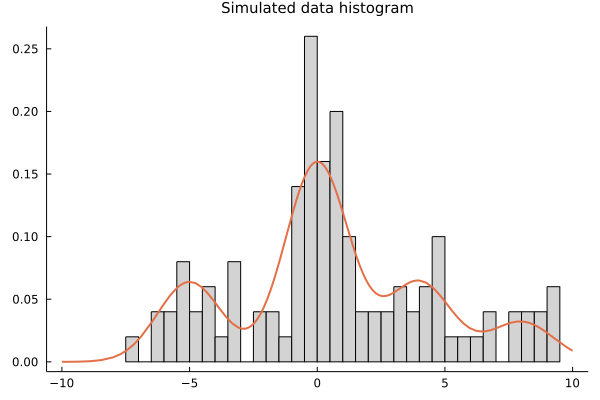

In [4]:
# parameters
μ = [-5, 0, 4, 8]
τ = 0.8
π = [0.2, 0.5, 0.2, 0.1]
K = length(π)
N = 100

# data simulation
Y = zeros(0)
for i in range(1, K)
    append!(Y, rand(Normal(μ[i], 1/τ), Int(N * π[i])))
end;

# plot the histogram and the pdf
function f(x, π, μ, τ)
    y = 0
    K = length(π)
    for i in range(1, K)
        y += π[i] * pdf(Normal(μ[i], 1/τ), x)
    end
    y
end

g(x) = f(x, π, μ, τ)
histogram(Y, bins=50, normed=true, title="Simulated data histogram")
plot!(g, -10, 10, width=2)

### Gibs sampler for a Gaussian mixture

In [8]:
function draw_Z(y; μ, π, τ)
    K = length(π)
    p = zeros(K)
    for i in range(1, K)
        p[i] = pdf(Normal(μ[i], 1/τ), y) * π[i]
    end
    p = p ./ sum(p)
    sample([1:1:K;], Weights(p))
end

function mix_gibbs_sample(;data, α0, τ0, μ0, N_iter=1000)
    Y = data
    K = length(α0)
    prior_π = Dirichlet(α0)
    prior_μ = Normal(μ0, 1/τ0)  # the same prior for all mixtures
    n = length(Y)  # number of data points
    col_μ = [1:1:K;]
    col_π = [K+1:1:2*K;]
    X = Array{Float64, 2}(undef, N_iter, 2*K)

    # draw starting values
    X[1, col_μ] = sort(rand(prior_μ, K))
    X[1, col_π] = rand(prior_π)

    for t in range(2, N_iter)
        # draw Z1, ..., Zn
        Z = draw_Z.(Y, μ=X[t - 1, col_μ], π=X[t - 1, col_π], τ=τ)
        # draw μ1, ..., μK
        cts = [sum(Z .== k) for k in range(1, K)]
        new_μ = zeros(K)
        for k in range(1, K)
            τ_k = (cts[k] * τ + τ0)
            new_μ[k] = sum(Y[Z .== k]) * τ + τ0*μ0
            new_μ[k] = new_μ[k] / τ_k
            X[t, k] = rand(Normal(new_μ[k], 1 / τ_k))
        end
        # draw π1, ..., πK
        X[t, col_π] = rand(Dirichlet(α0 .+ cts))
        X
    end
    X
end;

In [9]:
N_iter = 1000
α0 = fill(1, K)
τ0 = 0.5
μ0 = 0
X = mix_gibbs_sample(data=Y, α0=α0, τ0=τ0, μ0=μ0, N_iter=N_iter)
col_μ = [1:1:K;]
col_π = [K+1:1:2*K;];

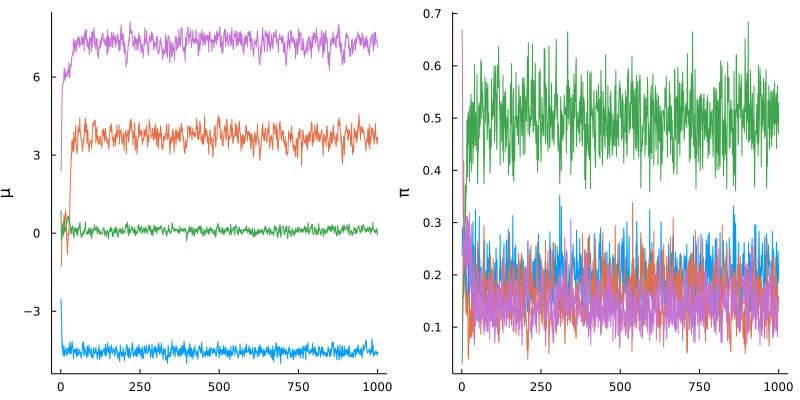

In [11]:
# trace plots
plot(X[:, col_μ], layout = (1,2), size = (800, 400), subplot=1, ylab="\\mu")
plot!(X[:, col_π], subplot=2, ylab="\\pi")

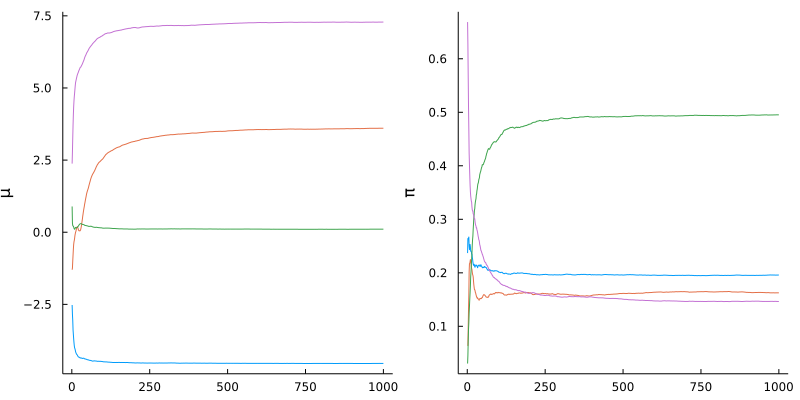

In [12]:
# ergodic averages
Z = cumsum(X, dims=1) ./ [1:1:N_iter;]
plot(Z[:, col_μ], layout = (1,2), size = (800, 400), subplot=1, ylab="\\mu")
plot!(Z[:, col_π], subplot=2, ylab="\\pi")

In [16]:
println("Estimated means:", round.(Z[N_iter, col_μ], digits=2))
println("Estimated probabilities:", round.(Z[N_iter, col_π], digits=2))

println("\nTrue means:", μ)
println("Ture probabilities:", π)

Estimated means:[-4.55, 3.6, 0.11, 7.28]
Estimated probabilities:[0.2, 0.16, 0.5, 0.15]

True means:[-5, 0, 4, 8]
Ture probabilities:[0.2, 0.5, 0.2, 0.1]


## The Ising Model

The Ising model specifies a probability distribution over the possible values {-1, +1} that each vertex $x_i$ in a lattice graph can take:
$$f(x_1, \ldots, x_m) = \frac{1}{Z}\exp{\left(J\sum_{(i, j) \in \mathcal{E}}{x_ix_j}\right)}$$

### Simple Gibbs Sampler
We can implement a simple Gibbs Sampler by noting that the full conditional distributions are given by:
$$f_{X_j | X_{-j}}(x_j | x_{-j}) = \exp{\left(J\sum_{i\sim j}{x_ix_j}\right)} / \left[ \exp{\left(-J\sum_{i\sim j}{x_i}\right)} + \exp{\left(J\sum_{i\sim j}{x_i}\right)} \right]$$

In [17]:
function sample_node(i, j, X, J)
    neighbours = [X[i, j+1] X[i, j-1] X[i+1, j] X[i-1, j]]
    num = exp(J * sum(neighbours))
    denom = exp(-J * sum(neighbours)) + exp(J * sum(neighbours))
    p = num / denom  # probability of +1
    q = 1 - p
    sample([1, -1], Weights([p, q]))
end

function initialise_graph(M)
    # initialise the graph with ones and zeros on borders
    X = convert(Matrix{Int32}, zeros(M + 1, M + 1))
    for i in range(2, M)
        for j in range(2, M)
            X[i, j] = 1
        end
    end
    X
end

function ising_simple_gibbs(J, M, N_iter=100)
    X = initialise_graph(M)
    for t in range(2, N_iter)
        for i in range(2, M)
            for j in range(2, M)
                X[i, j] = sample_node(i, j, X, J)
            end
        end
    end
    X[2:M, 2:M]
end

ising_simple_gibbs (generic function with 2 methods)

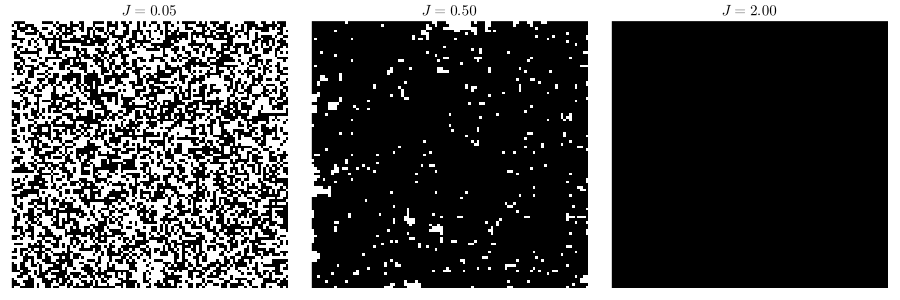

In [18]:
M = 100
X1 = ising_simple_gibbs(0.05, M)
X2 = ising_simple_gibbs(0.5, M)
X3 = ising_simple_gibbs(2, M)

default(legend=false, xticks=false, yticks=false, xaxis=false, 
    yaxis=false, fillcolor=:binary, titlefontsize=10)
heatmap(X1, size=(900,300), subplot=1, layout = (1,3), title=L"J=0.05")
heatmap!(X2, subplot=2, title=L"J=0.50")
heatmap!(X3, subplot=3, title=L"J=2.00")

When $J$ (relative to the size of the graph) is large, the vcorrelation between the adjacent states within the Ising model causes the Gibbs sampler to mix slowly.  The chain with $J=0.05$ has reached a state with littele in common with its starting vlaue, while that with $J=2.00$ has hardly moved from the starting values after 100th iteration.

### The Swendsen-Wang Algorithm

For every edge $(x_i, x_j)$ in the graph we add an auxilary random variable $u_{ij}$ withe distribution specified by the full conditionals:
$$u_{ij} | u_{-ij} \sim Bernoulli(\rho\mathbb{I}(x_i = x_j))$$
and $\rho = 1 - exp(-2J)$. 

We consider an extended target distribution:
$$f(\mathbf{x}, \mathbf{u}) \propto (1 - \rho)^{|E_{\Delta}| + |E_0|}\rho^{|E_1|}\prod_{(i,j) \in \mathcal{E}: u_{i,j} = 1}{\mathbb{I}(x_i = x_j)}$$
Where:
$$E_{\Delta} := \{(i,j): x_i \neq x_j\}, \quad E_{0} := \{(i,j): x_i = x_j, u_{ij} = 0\}, \quad E_{1} := \{(i,j): x_i = x_j, u_{ij} = 1\}$$


The Swendesn-Wang Algorithms is simply a block Gibbs sampler for this extended target distribution which prcoeeds iterativeley with two steps:
1. Sample $\mathbf{U}^{(t)} | \mathbf{X}^{(t-1)}$
1. Sample $\mathbf{X}^{(t)} | \mathbf{U}^{(t)}$

This can be implemented as follows:

**Cluster:** For $(i,j)\in \mathcal{E}$ sample:
$$U^t_{ij} \sim Bernoulli(\rho\mathbb{I}(x_i^{(t-1)} = x_j^{(t-1)}))$$

**Flip:**
1. Identify connected components.
2. Set every $X^t$ within each $U^t$-connected component to the same value sampled unfiormly from $\{+1, -1\}$.

In [19]:
using Graphs, MetaGraphs

function initialise_graph(M)
    G = MetaGraph(M*M)  # index of vertex [x, x] is [(x-1)*M + y]
    for i in range(1, M*M)
        set_prop!(G, i, :X, 1)
        for j in range(i + 1, M*M)
            if (abs(i-j) == 1 && i % M != 0) || abs(i-j) == M
                add_edge!(G, i, j)
                set_prop!(G, Edge(i, j), :U, 0)
            end
        end
    end  
    G
end

function update_edges(G, rho)
    for e in edges(G)
            s = src(e)
            d = dst(e) 
            if props(G, s)[:X] == props(G, d)[:X]
                props(G, s, d)[:U] = rand(Bernoulli(rho))

            end
        end
    G
end

function flip_nodes(G)
    # find U-connected components
    U = MetaGraph(M*M)  # graph with only bonding edges
    for e in edges(G)
        if props(G, e)[:U] == 1
            add_edge!(U, src(e), dst(e))
        end
    end
    # Flip the states of connected components
    for C in connected_components(U)
        if length(C) > 1
            state = sample([-1, 1])
            for v in C
                set_prop!(G, v, :X, state)
            end
        end
    end
    G
end

function to_matrix(G)
    X = convert(Matrix{Int32}, zeros(M, M))
    for i in range(1, M)
        for j in range(1, M)
            X[i, j] = props(G, (i - 1) * M + j)[:X]
        end
    end
    X
end

function swendsen_wang(J, M, N_iter=100)
    rho = 1 - exp(-2*J)
    G = initialise_graph(M)
    
    for t in range(2, N_iter)
        G = update_edges(G, rho)
        G = flip_nodes(G)
    end
    
    X = to_matrix(G)
    X
end

swendsen_wang (generic function with 2 methods)

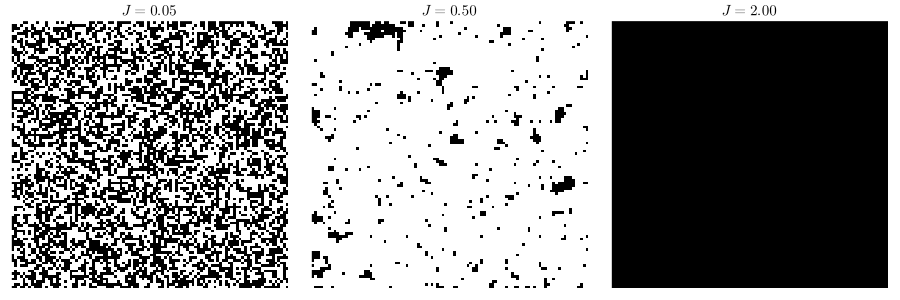

In [20]:
M = 100
X1 = swendsen_wang(0.05, M)
X2 = swendsen_wang(0.5, M)
X3 = swendsen_wang(2, M)

default(legend=false, xticks=false, yticks=false, xaxis=false, 
    yaxis=false, fillcolor=:binary, titlefontsize=10)
heatmap(X1, size=(900,300), subplot=1, layout = (1,3), title=L"J=0.05")
heatmap!(X2, subplot=2, title=L"J=0.50")
heatmap!(X3, subplot=3, title=L"J=2.00")